# K-Nearest Neighbors

Data set with samples $\vec{x}=~(x_1,x_2,x_3, \cdots, x_n))$ with categories $\vec{y}=~(y_1,y_2,y_3, \cdots, y_n))$

To predict a new sample $z$ we need to take a look at the $k$ nearest neighbors. For this, a regression is used if $~\vec{y}~$ is continuous or classification if $~\vec{y}~$ is discrete.
 
In discrete classification problems, the prediction is made by majority vote, weighting the distance of the $K$ neighbors with the point to be predicted:


In continuous regression problems, the prediction is made as the weighted average of the $K$ points closest to the one we want to predict.

$$ f(z)=~\sum_{i=1}^k \phi(d_i) ~=~ \sum_{i=1}^k w_i \cdot d_i $$

where:
- $w_i = \frac{1}{dist(x_{test},~ x_i) + \epsilon},~ \epsilon \in \mathbb R $
- $\epsilon$ to avoid division by zero 


The most used distances are:

- $d_{L1}(x,y)=~ |x-y| = |x_1 - y_1| + |x_2 - y_2| + \cdots + |x_n - y_n|$
- $d_{L2}(x,y)=~ ||x-y|| = \sqrt{(x_1 - y_1)^2 + (x_2 - y_2)^2 + \cdots + (x_n - y_n)}$

# Predicting the Sale Price of a House

### Boston Houses

**Variables**
There are 14 attributes in each case of the dataset. They are:
* CRIM - per capita crime rate by town
* ZN - proportion of residential land zoned for lots over 25,000 sq.ft.
* INDUS - proportion of non-retail business acres per town.
* CHAS - Charles River dummy variable (1 if tract bounds river; 0 otherwise)
* NOX - nitric oxides concentration (parts per 10 million)
* RM - average number of rooms per dwelling
* AGE - proportion of owner-occupied units built prior to 1940
* DIS - weighted distances to five Boston employment centres
* RAD - index of accessibility to radial highways
* TAX - full-value property-tax rate per 10,000USD
* PTRATIO - pupil-teacher ratio by town
* B - $1000(Bk - 0.63)^2$ where Bk is the proportion of blacks by town
* LSTAT - porcent lower status of the population
* MEDV - Median value of owner-occupied homes in $1000's

### Get Boston Housing Data

In [1]:
import requests

In [2]:
url = 'https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv'
req = requests.get(url)

if req.ok:
    raw_file = req.content.decode().split('\n')
    # Header
    header = raw_file[0].upper().replace('"', '').split(',')
    # Data
    housing_data = raw_file[1:]
    housing_data = [[float(x.replace('"', '')) for x in row.split(',')] for row in housing_data if len(row.split(',')) == 14]
    print(f'Data Sucessfully Loaded!')
else:
    print(f'Eror: Data could not be loaded, Status Code: {req.status_code}')

Data Sucessfully Loaded!


### Define Training and Testing set

In [3]:
import pandas as pd
import numpy as np

In [4]:
cols_used = ['CRIM','INDUS','NOX','RM','AGE','DIS','TAX','PTRATIO','B','LSTAT', 'MEDV']
df = pd.DataFrame(housing_data, columns= header).loc[:, cols_used]
df.head(5)

,CRIM,INDUS,NOX,RM,AGE,DIS,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,2.31,0.538,6.575,65.2,4.0900,296.0,15.3,396.90,4.98,24.0
1,0.02731,7.07,0.469,6.421,78.9,4.9671,242.0,17.8,396.90,9.14,21.6
2,0.02729,7.07,0.469,7.185,61.1,4.9671,242.0,17.8,392.83,4.03,34.7
3,0.03237,2.18,0.458,6.998,45.8,6.0622,222.0,18.7,394.63,2.94,33.4
4,0.06905,2.18,0.458,7.147,54.2,6.0622,222.0,18.7,396.90,5.33,36.2


In [5]:
x_vals = df.iloc[:, :-1].values
y_vals = df.MEDV.values

# Normalize data
min = x_vals.min(axis= 0)
max = x_vals.max(axis= 0)
x_norm = (x_vals - min) / (max - min)

# Define training and testing set
train_size = int(x_norm.shape[0] * 0.9)
perm = np.random.permutation(x_norm.shape[0])

x_train = x_norm[ perm[:train_size] ]
y_train = y_vals[ perm[:train_size] ]

x_test = x_norm[ perm[train_size:] ]
y_test = y_vals[ perm[train_size:] ]

print(f'Training: {x_train.shape} \n Testing: {x_test.shape}')

Training: (455, 10) 
 Testing: (51, 10)


### K-Nearest Neighbors

In [6]:
import tensorflow as tf
import matplotlib.pyplot as plt

plt.style.use('ggplot')

In [7]:
# Define Data
x_train_set = tf.constant(x_train, dtype= tf.float32)
x_test_set = tf.constant(x_test, dtype= tf.float32)

y_train_set = tf.constant(y_train, dtype= tf.float32)
y_test_set = tf.constant(y_test, dtype= tf.float32)

In [8]:
class KNearestRegression:
    """
        Parameters.
                    - distance_metric. l1 or l2
                    - k_neighbors. Int number of K-Neighbors to predict.
    """
    def __init__(self, k_neighbors= 5, distance_metric = 'l1'):
        self.k_neighbors= k_neighbors
        self.distance_metric = distance_metric
        self._x_data = []
        self._y_data = []

    # Function to get distance either l1 or l2
    def norm(self, values):
        if self.distance_metric == 'l1':
            return tf.reduce_sum(tf.abs(tf.expand_dims(values, 1) - self._x_data), axis= 2)
        elif self.distance_metric == 'l2':
            return tf.reduce_sum(tf.square(tf.expand_dims(values, 1) - self._x_data), axis= 2)
        else:
            raise ValueError('Invalid Distance Metric. Use l1 or l2.')

    # Define the data
    def fit(self, x, y):
        self._x_data = x
        self._y_data = y

    # Function to predict
    def predict(self, data):
        distance = self.norm(data)
        k_values, k_ind = tf.nn.top_k(tf.negative(distance), k= self.k_neighbors) # K Neighbors
        k_values = tf.negative(k_values)  
        k_nearest = tf.gather(self._y_data, k_ind)
        weights = k_values / tf.reduce_sum(k_values, axis= 1, keepdims= True)
        pred_output = tf.reduce_sum(weights * k_nearest, axis= 1)
        return pred_output

    # Get MSE and MAE
    def score(self, x, y):
        y_pred = self.predict(x)
        mse = tf.reduce_mean(tf.square(y - y_pred))
        mae = tf.sqrt(mse)
        print(f'* MSE: {mse} -- * MAE: {mae}')

In [9]:
# Define the optimal number of K-Neighbors
for n in range(2, 21, 2):
    print(f'K-Neighbors: {n}')
    model = KNearestRegression(k_neighbors= n, distance_metric= 'l2')
    model.fit(x_train_set, y_train_set)
    model.score(x_test_set, y_test_set)

K-Neighbors: 2
* MSE: 10.241110801696777 -- * MAE: 3.2001736164093018
K-Neighbors: 4
* MSE: 10.10499095916748 -- * MAE: 3.178834915161133
K-Neighbors: 6
* MSE: 19.379560470581055 -- * MAE: 4.402222156524658
K-Neighbors: 8
* MSE: 20.704496383666992 -- * MAE: 4.550219535827637
K-Neighbors: 10
* MSE: 26.455211639404297 -- * MAE: 5.143463134765625
K-Neighbors: 12
* MSE: 25.80560874938965 -- * MAE: 5.079922199249268
K-Neighbors: 14
* MSE: 25.68373680114746 -- * MAE: 5.067912578582764
K-Neighbors: 16
* MSE: 24.147836685180664 -- * MAE: 4.9140448570251465
K-Neighbors: 18
* MSE: 20.709941864013672 -- * MAE: 4.550817489624023
K-Neighbors: 20
* MSE: 20.100629806518555 -- * MAE: 4.483372688293457


In [10]:
model = KNearestRegression(k_neighbors= 4, distance_metric= 'l2')
model.fit(x_train_set, y_train_set)
model.score(x_test_set, y_test_set)

* MSE: 10.10499095916748 -- * MAE: 3.178834915161133


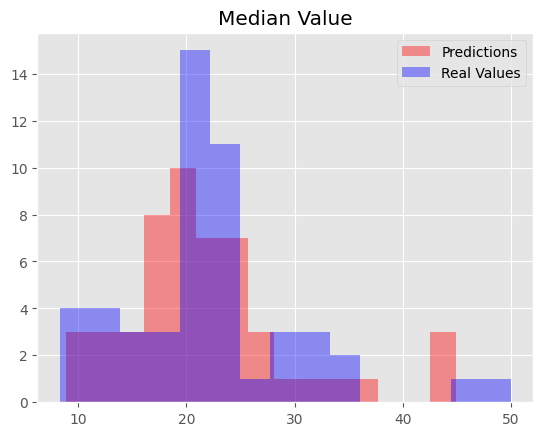

In [11]:
predictions = model.predict(x_test_set)

plt.hist(predictions, label = "Predictions", color= 'red', alpha= 0.4, bins= 15)
plt.hist(y_test_set, label = "Real Values", color= 'blue', alpha= 0.4, bins= 15)

plt.title('Median Value')
plt.legend()
plt.show()